This notebook uses two variance tests to look for best variance explained using clustering on all cell types coding scores in Visual Behavior dataset

## Load clustering results 



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pickle
from brain_observatory_qc.data_access import from_lims_utilities
import glob
import h5py
import re

In [2]:
# Directory path
directory = '//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_plots/figure_4/all_cre_clustering_090923_select_k/'

# Regular expression to match the desired file names
pattern = r'cluster_meta_n_(\d+)_clusters\.h5'

# Function to extract the number from the file name
def extract_number(filename):
    match = re.search(pattern, filename)
    if match:
        return int(match.group(1))
    return -1

# Get a list of all files in the directory
all_files = os.listdir(directory)

# Filter and sort the files based on the number in their names
filtered_files = [filename for filename in all_files if re.match(pattern, filename)]
sorted_files = sorted(filtered_files, key=extract_number)

cluster_metas = []
# Load the selected HDF5 files
for filename in sorted_files:
    file_path = os.path.join(directory, filename)
    
    cluster_metas.append( pd.read_hdf(file_path, key='df'))
    print(f"Processing {filename}")

Processing cluster_meta_n_4_clusters.h5
Processing cluster_meta_n_5_clusters.h5
Processing cluster_meta_n_6_clusters.h5
Processing cluster_meta_n_7_clusters.h5
Processing cluster_meta_n_8_clusters.h5
Processing cluster_meta_n_9_clusters.h5
Processing cluster_meta_n_10_clusters.h5
Processing cluster_meta_n_11_clusters.h5
Processing cluster_meta_n_12_clusters.h5
Processing cluster_meta_n_13_clusters.h5
Processing cluster_meta_n_14_clusters.h5
Processing cluster_meta_n_15_clusters.h5
Processing cluster_meta_n_16_clusters.h5
Processing cluster_meta_n_17_clusters.h5
Processing cluster_meta_n_18_clusters.h5
Processing cluster_meta_n_19_clusters.h5
Processing cluster_meta_n_20_clusters.h5
Processing cluster_meta_n_21_clusters.h5
Processing cluster_meta_n_22_clusters.h5
Processing cluster_meta_n_23_clusters.h5
Processing cluster_meta_n_24_clusters.h5


In [3]:
feature_matrix = pd.read_hdf(os.path.join(directory, '24_events_all_L2_optimize_by_session_feature_matrix.h5'), key='df')

#### Define functions

In [4]:

def get_coding_clusters_df(feature_matrix, cluster_meta):
    df = feature_matrix.merge(cluster_meta[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id', how='inner')
    coding_clusters_df = df.set_index('cell_specimen_id')
    return coding_clusters_df

In [5]:
def between_group_variability(cluster_means, overall_mean, cluster_sample_sizes):
    """
    Compute between-group variability.

    Parameters:
    - cluster_means (list or numpy array): A list or array containing the means of each group.
    - overall_mean (float): The overall mean of all the data points.
    - cluster_sample_sizes (list or numpy array): A list or array containing the sample sizes (number of data points) for each group.

    Returns:
    - float: The computed between-group variability.
    """
    K = len(cluster_means)  # Number of groups
    between_group_var = sum(cluster_sample_sizes[i] * (cluster_means[i] - overall_mean)**2 for i in range(K)) / (K - 1)
    
    return between_group_var




In [7]:
def within_group_variability(cluster_data, cluster_means, overall_mean):
    """
    Compute within-group variability.

    Parameters:
    - cluster_data (list of lists or numpy arrays): A list of lists or arrays, where each inner list or array contains
      the data points for a specific cluster.
    - cluster_means (list or numpy array): A list or array containing the means of each cluster.
    - overall_mean (float): The overall mean of all the data points.
    

    Returns:
    - float: The computed within-group variability.
    """
    num_clusters = len(cluster_means)
    N = sum(len(cluster) for cluster in cluster_data)  # Overall sample size        
    
    within_group_var = sum(sum((Y - cluster_means[i])**2 for Y in cluster) for i, cluster in enumerate(cluster_data)) / (N - num_clusters)
    
    return within_group_var




In [6]:
def get_cluster_params(coding_clusters_df):
    
    cluster_means = coding_clusters_df.groupby('cluster_id').mean().values
    overall_mean = coding_clusters_df.drop(['cluster_id'], axis = 1).mean().values
    cluster_sample_sizes = coding_clusters_df.value_counts(['cluster_id']).sort_index().values
    
    cluster_ids = np.sort(coding_clusters_df.cluster_id.unique())
    cluster_data=[]
    for cluster_id in cluster_ids:
        cluster_data.append(coding_clusters_df[coding_clusters_df.cluster_id==cluster_id].drop(['cluster_id'], axis=1).values)
    
    return cluster_data, cluster_means, overall_mean, cluster_sample_sizes

#### Loop through all k cluster metas and compute F statistic

In [9]:
between_group_vars = []
within_group_vars = []
F_statistics = []
for cluster_meta in cluster_metas:
    coding_clusters_df = get_coding_clusters_df(feature_matrix, cluster_meta)
    cluster_data, cluster_means, overall_mean, cluster_sample_sizes = get_cluster_params(coding_clusters_df)
    
    between_group_var = between_group_variability(cluster_means, overall_mean, cluster_sample_sizes)
    within_group_var = within_group_variability(cluster_data, cluster_means, overall_mean)

    between_group_vars.append(between_group_var)
    within_group_vars.append(within_group_var)
    
    F = between_group_var/within_group_var
    F_statistics.append(F)
    

In [27]:
within_group_var

array([0.02163116, 0.02601789, 0.01977322, 0.00880652, 0.00603861,
       0.01104792, 0.01027101, 0.0105304 , 0.01003688, 0.00408111,
       0.00572579, 0.00388244])

In [26]:
between_group_var

array([18.33061043, 23.3088737 , 20.15995479,  1.45349839,  0.19679357,
        0.79678377,  0.79577165,  1.10894955,  1.41181265,  0.85335122,
        1.12065503,  0.84007968])

#### Plot F statistic 

In [60]:
folder = 'plots'
directory_path =os.path.join(directory, folder)
if not os.path.exists(directory_path):
    # If it doesn't exist, create it
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' created.")

Directory '//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_plots/figure_4/all_cre_clustering_090923_select_k/plots' created.


In [68]:
# Plot F values for each feature across various ks
# save in the directopry_path defined above
k_clusters = np.arange(4,25)
F_mean = 1# np.median(F_statistics, axis=0)

note = 'raw'

for i, F in enumerate(F_statistics):
    figname = os.path.join(directory_path, f'Fvalue_{note}_k{k_clusters[i]}.png')
    x = coding_clusters_df.drop(['cluster_id'], axis = 1).keys()
                           
    fig = plt.figure(figsize = (10,4))
    plt.plot(range(len(x)), F/F_mean)
    plt.xticks(ticks = range(len(x)), labels = x, rotation=90)
    plt.title(f'number of clusters = {k_clusters[i]}')
    plt.ylabel('F value (normalized)')
    plt.tight_layout()
    fig.savefig(figname)
    plt.close('all')

#### Plot cummulative data 

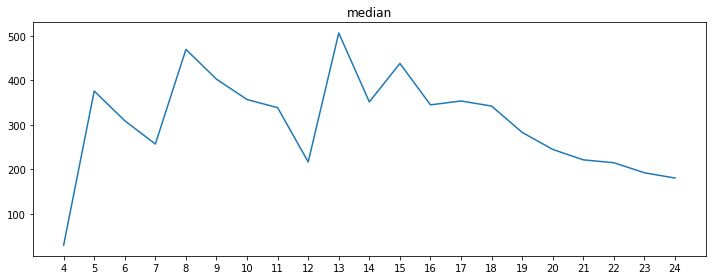

In [84]:
fig = plt.figure(figsize = (10,4))
plt.plot(k_clusters,np.median(F_statistics, axis=1))
note = 'median'
plt.title(note)
plt.xticks(k_clusters, )
figname = os.path.join(directory_path, f'Fvalue_{note}.png')
plt.tight_layout()
fig.savefig(figname)

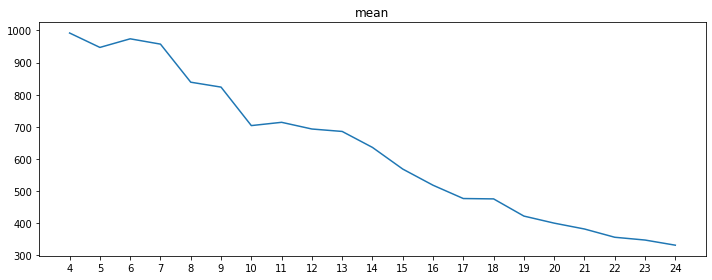

In [86]:
fig = plt.figure(figsize = (10,4))
plt.plot(k_clusters,np.mean(F_statistics, axis=1))
note = 'mean'
plt.title(note)
plt.xticks(k_clusters, )
figname = os.path.join(directory_path, f'Fvalue_{note}.png')
plt.tight_layout()
fig.savefig(figname)

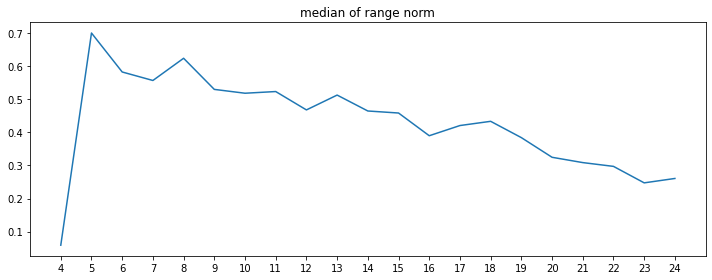

In [92]:
fig = plt.figure(figsize = (10,4))
plt.plot(k_clusters,np.median(F_statistics/(np.max(F_statistics, axis=0) - np.min(F_statistics, axis=0)), axis=1))
note = 'median of range norm'
plt.title(note)
plt.xticks(k_clusters, )
figname = os.path.join(directory_path, f'Fvalue_{note}.png')
plt.tight_layout()
fig.savefig(figname)


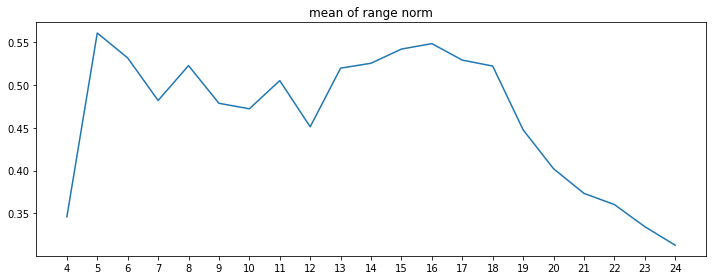

In [91]:
fig = plt.figure(figsize = (10,4))
plt.plot(k_clusters,np.mean(F_statistics/(np.max(F_statistics, axis=0) - np.min(F_statistics, axis=0)), axis=1))
note = 'mean of range norm'
plt.title(note)
plt.xticks(k_clusters, )
figname = os.path.join(directory_path, f'Fvalue_{note}.png')
plt.tight_layout()
fig.savefig(figname)


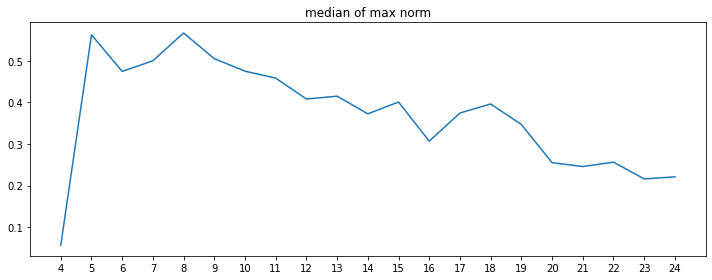

In [87]:
fig = plt.figure(figsize = (10,4))
plt.plot(k_clusters,np.median(F_statistics/np.max(F_statistics, axis=0), axis=1))
note = 'median of max norm'
plt.title(note)
plt.xticks(k_clusters, )
figname = os.path.join(directory_path, f'Fvalue_{note}.png')
plt.tight_layout()
fig.savefig(figname)


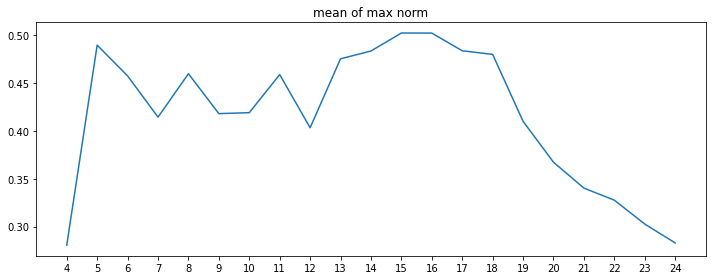

In [89]:
fig = plt.figure(figsize = (10,4))
plt.plot(k_clusters,np.mean(F_statistics/np.max(F_statistics, axis=0), axis=1))
note = 'mean of max norm'
plt.title(note)
plt.xticks(k_clusters, )
figname = os.path.join(directory_path, f'Fvalue_{note}.png')
plt.tight_layout()
fig.savefig(figname)


#### Mannwhitneyu test

In [55]:
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import kruskal


In [ ]:
for cluster_meta in cluster_metas:
    coding_clusters_df = get_coding_clusters_df(feature_matrix, cluster_meta)
    cluster_data, cluster_means, overall_mean, cluster_sample_sizes = get_cluster_params(coding_clusters_df)
    
    
    

In [56]:
U, p = mwu(cluster_data[0], cluster_data[1])

Kruscal needs one dimenional data, in order to use the mean of the coding scores they need to be standardized

`kruskal(cluster_data[0], cluster_data[1])`

--------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
~\AppData\Local\Temp\ipykernel_13384\116073849.py in <module>
----> 1 kruskal(cluster_data[0], cluster_data[1])

~\Anaconda3\envs\vba\lib\site-packages\scipy\stats\stats.py in kruskal(nan_policy, *args)
   7867             return KruskalResult(np.nan, np.nan)
   7868         elif arg.ndim != 1:
-> 7869             raise ValueError("Samples must be one-dimensional.")
   7870 
   7871     n = np.asarray(list(map(len, args)))

ValueError: Samples must be one-dimensional.

**Note**: example of this test is with standardized data later in the notebook

#### Nomalize coding scores

In [152]:
# normalize
between_group_vars_norm = []
within_group_vars_norm = []
F_statistics_norm = []
for cluster_meta in cluster_metas:
    coding_clusters_df = get_coding_clusters_df(feature_matrix, cluster_meta)
    
    #normalize
    normalized_df = coding_clusters_df.drop(columns=['cluster_id'])-coding_clusters_df.drop(columns=['cluster_id']).mean()
    normalized_df['cluster_id'] = coding_clusters_df['cluster_id'].values
    
    
    cluster_data, cluster_means, overall_mean, cluster_sample_sizes = get_cluster_params(normalized_df)
    
    between_group_var= between_group_variability(cluster_means, overall_mean, cluster_sample_sizes)
    within_group_var = within_group_variability(cluster_data, cluster_means, overall_mean)

    between_group_vars_norm.append(between_group_var)
    within_group_vars_norm.append(within_group_var)
    
    F = between_group_var/within_group_var
    F_statistics_norm.append(F)

C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\pandas\core\frame.py:9203: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  validate=validate,


In [153]:
# Plot F values for each feature across various ks
# save in the directopry_path defined above
k_clusters = np.arange(4,25)
F_mean = 1# np.median(F_statistics, axis=0)

note = 'normalized_coding_scores'

for i, F in enumerate(F_statistics_norm):
    figname = os.path.join(directory_path, f'Fvalue_{note}_k{k_clusters[i]}.png')
    x = coding_clusters_df.drop(['cluster_id'], axis = 1).keys()
                           
    fig = plt.figure(figsize = (10,4))
    plt.plot(range(len(x)), F/F_mean)
    plt.xticks(ticks = range(len(x)), labels = x, rotation=90)
    plt.title(f'number of clusters = {k_clusters[i]}')
    plt.ylabel('F value (normalized)')
    plt.tight_layout()
    fig.savefig(figname)
    plt.close('all')

#### Plot cummulative data 

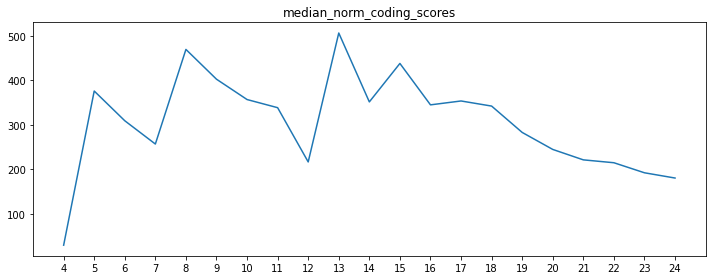

In [155]:
fig = plt.figure(figsize = (10,4))
plt.plot(k_clusters,np.median(F_statistics_norm, axis=1))
note = 'median_norm_coding_scores'
plt.title(note)
plt.xticks(k_clusters, )
figname = os.path.join(directory_path, f'Fvalue_{note}.png')
plt.tight_layout()
fig.savefig(figname)

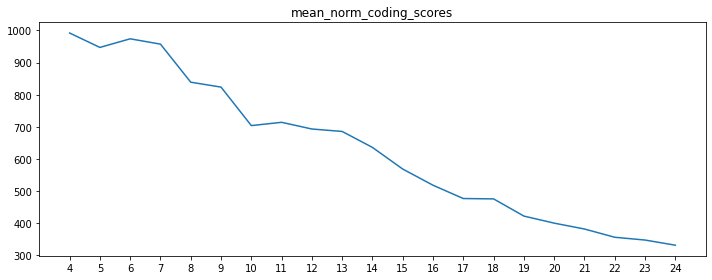

In [156]:
fig = plt.figure(figsize = (10,4))
plt.plot(k_clusters,np.mean(F_statistics_norm, axis=1))
note = 'mean_norm_coding_scores'
plt.title(note)
plt.xticks(k_clusters, )
figname = os.path.join(directory_path, f'Fvalue_{note}.png')
plt.tight_layout()
fig.savefig(figname)

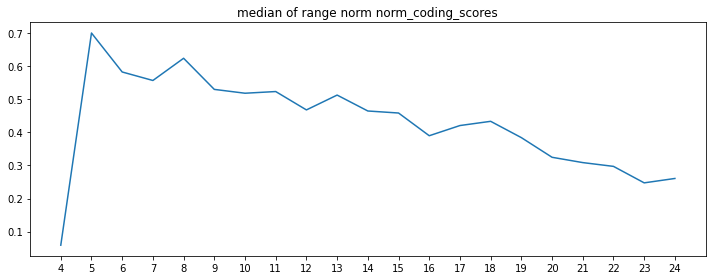

In [157]:
fig = plt.figure(figsize = (10,4))
plt.plot(k_clusters,np.median(F_statistics_norm/(np.max(F_statistics_norm, axis=0) - np.min(F_statistics_norm, axis=0)), axis=1))
note = 'median of range norm norm_coding_scores'
plt.title(note)
plt.xticks(k_clusters, )
figname = os.path.join(directory_path, f'Fvalue_{note}.png')
plt.tight_layout()
fig.savefig(figname)


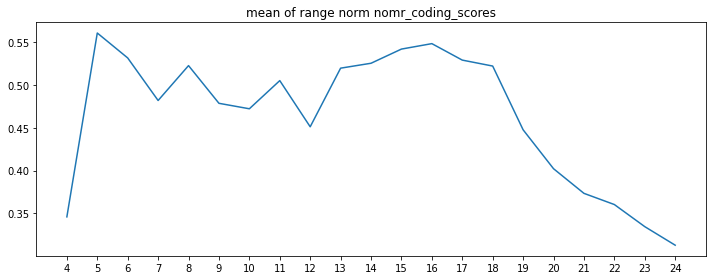

In [158]:
fig = plt.figure(figsize = (10,4))
plt.plot(k_clusters,np.mean(F_statistics_norm/(np.max(F_statistics_norm, axis=0) - np.min(F_statistics_norm, axis=0)), axis=1))
note = 'mean of range norm nomr_coding_scores'
plt.title(note)
plt.xticks(k_clusters, )
figname = os.path.join(directory_path, f'Fvalue_{note}.png')
plt.tight_layout()
fig.savefig(figname)


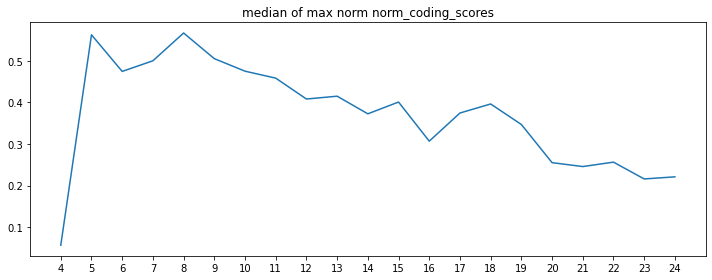

In [159]:
fig = plt.figure(figsize = (10,4))
plt.plot(k_clusters,np.median(F_statistics_norm/np.max(F_statistics_norm, axis=0), axis=1))
note = 'median of max norm norm_coding_scores'
plt.title(note)
plt.xticks(k_clusters, )
figname = os.path.join(directory_path, f'Fvalue_{note}.png')
plt.tight_layout()
fig.savefig(figname)


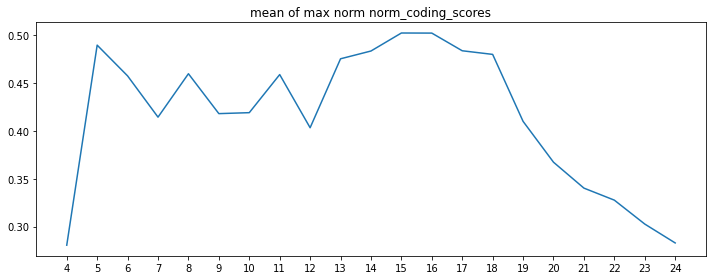

In [160]:
fig = plt.figure(figsize = (10,4))
plt.plot(k_clusters,np.mean(F_statistics_norm/np.max(F_statistics_norm, axis=0), axis=1))
note = 'mean of max norm norm_coding_scores'
plt.title(note)
plt.xticks(k_clusters, )
figname = os.path.join(directory_path, f'Fvalue_{note}.png')
plt.tight_layout()
fig.savefig(figname)


#### Standardize coding scores

In [165]:
# standardize
between_group_vars_stand = []
within_group_vars_stand = []
F_statistics_stand = []
for cluster_meta in cluster_metas:
    coding_clusters_df = get_coding_clusters_df(feature_matrix, cluster_meta)
    
    standardize_df = (coding_clusters_df.drop(columns=['cluster_id'])-coding_clusters_df.drop(columns=['cluster_id']).mean())/coding_clusters_df.drop(columns=['cluster_id']).std()
    standardize_df['cluster_id'] = coding_clusters_df['cluster_id'].values
    
    
    cluster_data, cluster_means, overall_mean, cluster_sample_sizes = get_cluster_params(standardize_df)
    
    between_group_var= between_group_variability(cluster_means, overall_mean, cluster_sample_sizes)
    within_group_var = within_group_variability(cluster_data, cluster_means, overall_mean)

    between_group_vars_stand.append(between_group_var)
    within_group_vars_stand.append(within_group_var)
    
    F = between_group_var/within_group_var
    F_statistics_stand.append(F)

C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\pandas\core\frame.py:9203: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  validate=validate,


In [177]:
# Plot F values for each feature across various ks
# save in the directopry_path defined above
k_clusters = np.arange(4,25)
F_mean = 1# np.median(F_statistics, axis=0)

note = 'standardized_coding_scores'

for i, F in enumerate(F_statistics_stand):
    figname = os.path.join(directory_path, f'Fvalue_{note}_k{k_clusters[i]}.png')
    x = coding_clusters_df.drop(['cluster_id'], axis = 1).keys()
                           
    fig = plt.figure(figsize = (10,4))
    plt.plot(range(len(x)), F/F_mean)
    plt.xticks(ticks = range(len(x)), labels = x, rotation=90)
    plt.title(f'number of clusters = {k_clusters[i]}')
    plt.ylabel('F value')
    plt.tight_layout()
    #fig.savefig(figname)
    plt.close('all')

#### Plot cummulative data 

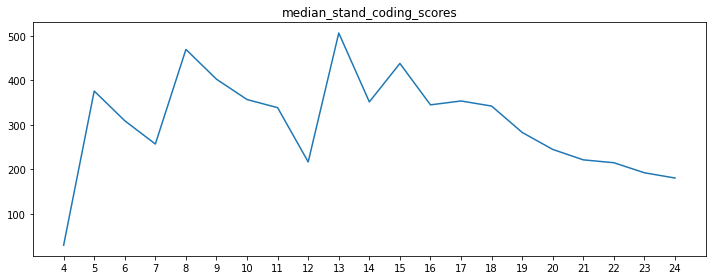

In [166]:
fig = plt.figure(figsize = (10,4))
plt.plot(k_clusters,np.median(F_statistics_stand, axis=1))
note = 'median_stand_coding_scores'
plt.title(note)
plt.xticks(k_clusters, )
figname = os.path.join(directory_path, f'Fvalue_{note}.png')
plt.tight_layout()
fig.savefig(figname)

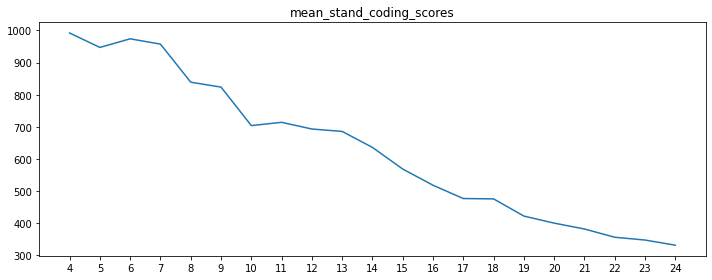

In [168]:
fig = plt.figure(figsize = (10,4))
plt.plot(k_clusters,np.mean(F_statistics_stand, axis=1))
note = 'mean_stand_coding_scores'
plt.title(note)
plt.xticks(k_clusters, )
figname = os.path.join(directory_path, f'Fvalue_{note}.png')
plt.tight_layout()
fig.savefig(figname)

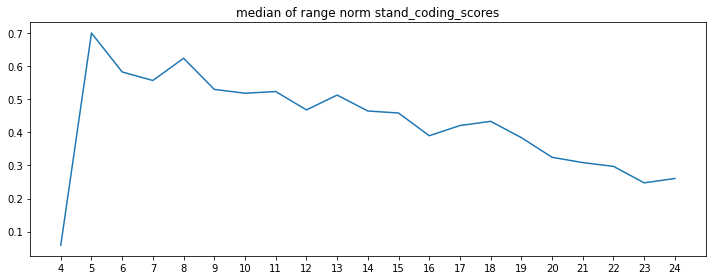

In [169]:
fig = plt.figure(figsize = (10,4))
plt.plot(k_clusters,np.median(F_statistics_stand/(np.max(F_statistics_stand, axis=0) - np.min(F_statistics_stand, axis=0)), axis=1))
note = 'median of range norm stand_coding_scores'
plt.title(note)
plt.xticks(k_clusters, )
figname = os.path.join(directory_path, f'Fvalue_{note}.png')
plt.tight_layout()
fig.savefig(figname)


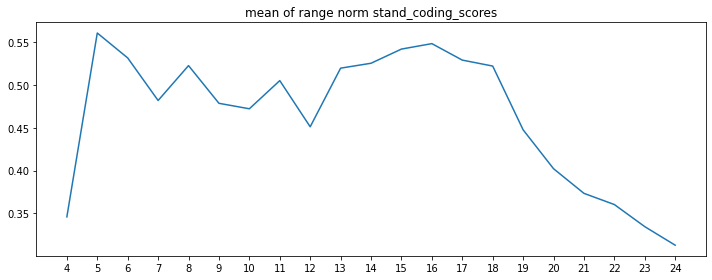

In [170]:
fig = plt.figure(figsize = (10,4))
plt.plot(k_clusters,np.mean(F_statistics_stand/(np.max(F_statistics_stand, axis=0) - np.min(F_statistics_stand, axis=0)), axis=1))
note = 'mean of range norm stand_coding_scores'
plt.title(note)
plt.xticks(k_clusters, )
figname = os.path.join(directory_path, f'Fvalue_{note}.png')
plt.tight_layout()
fig.savefig(figname)


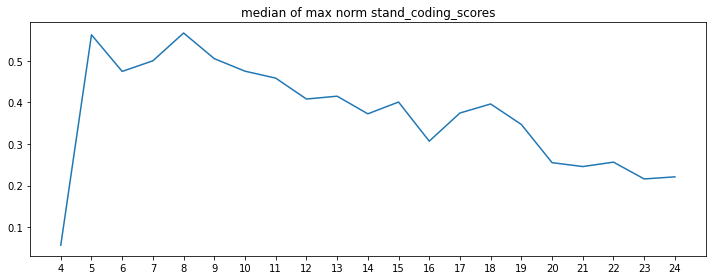

In [171]:
fig = plt.figure(figsize = (10,4))
plt.plot(k_clusters,np.median(F_statistics_stand/np.max(F_statistics_stand, axis=0), axis=1))
note = 'median of max norm stand_coding_scores'
plt.title(note)
plt.xticks(k_clusters, )
figname = os.path.join(directory_path, f'Fvalue_{note}.png')
plt.tight_layout()
fig.savefig(figname)


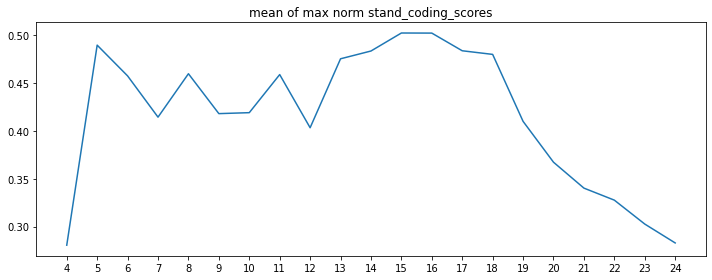

In [172]:
fig = plt.figure(figsize = (10,4))
plt.plot(k_clusters,np.mean(F_statistics_stand/np.max(F_statistics_stand, axis=0), axis=1))
note = 'mean of max norm stand_coding_scores'
plt.title(note)
plt.xticks(k_clusters, )
figname = os.path.join(directory_path, f'Fvalue_{note}.png')
plt.tight_layout()
fig.savefig(figname)


In [179]:
F_statistics[0]

array([4672.23838639, 3187.32624864, 3829.28809328,    8.35829578,
         13.41107955,    8.46705623,   47.95569324,   51.20477608,
         33.60717898,   25.51240166,   19.18028254,    9.08166263])

In [181]:
F_statistics_stand[0]

array([4672.23838639, 3187.32624864, 3829.28809328,    8.35829578,
         13.41107955,    8.46705623,   47.95569324,   51.20477608,
         33.60717898,   25.51240166,   19.18028254,    9.08166263])

*Note*: interestingly, the F statistic is the same whether F is computed on raw, normnalized or standardized values.

#### Kruskal with standarlized data

In [187]:
for cluster_meta in cluster_metas:
    coding_clusters_df = get_coding_clusters_df(feature_matrix, cluster_meta)
    
    standardize_df = (coding_clusters_df.drop(columns=['cluster_id'])-coding_clusters_df.drop(columns=['cluster_id']).mean())/coding_clusters_df.drop(columns=['cluster_id']).std()
    standardize_df['cluster_id'] = coding_clusters_df['cluster_id'].values
    
    
    cluster_data, cluster_means, overall_mean, cluster_sample_sizes = get_cluster_params(standardize_df)
    
    kruskal(np.mean(cluster_data[0], axis=0), np.mean(cluster_data[1], axis=0))

array([-0.64898827, -0.98817989, -0.79829582, -0.29963302, -0.29488729,
       -0.28051905, -0.28617137, -0.35421898, -0.34807683, -0.35032414,
       -0.43223694, -0.37315107])

In [195]:
kruskal(np.mean(cluster_data[0], axis=1), np.mean(cluster_data[1], axis=1),np.mean(cluster_data[2], axis=1))

KruskalResult(statistic=1265.7150546610007, pvalue=1.4238624907780271e-275)

### test code

Between-group variability: [1.19131347e+02 1.35819499e+02 1.21181138e+02 1.38841472e-01
 9.25409200e-02 1.31215702e-01 6.70611787e-01 8.06867545e-01
 5.73874168e-01 2.27200304e-01 2.17334846e-01 7.43966159e-02]


([<matplotlib.axis.XTick at 0x2497ebe2488>,
 [Text(0, 0, "('all-images', 'Familiar')"),
  Text(1, 0, "('all-images', 'Novel 1')"),
  Text(2, 0, "('all-images', 'Novel >1')"),
  Text(3, 0, "('omissions', 'Familiar')"),
  Text(4, 0, "('omissions', 'Novel 1')"),
  Text(5, 0, "('omissions', 'Novel >1')"),
  Text(6, 0, "('behavioral', 'Familiar')"),
  Text(7, 0, "('behavioral', 'Novel 1')"),
  Text(8, 0, "('behavioral', 'Novel >1')"),
  Text(9, 0, "('task', 'Familiar')"),
  Text(10, 0, "('task', 'Novel 1')"),
  Text(11, 0, "('task', 'Novel >1')")])

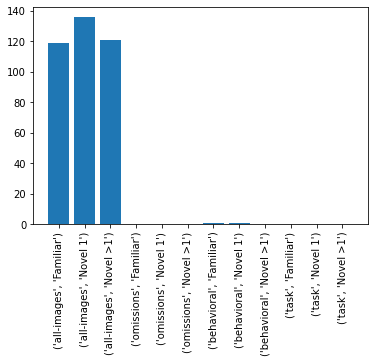

In [207]:
between_group_var = between_group_variability(cluster_means, overall_mean, cluster_sample_sizes)
print(f"Between-group variability: {between_group_var}")
x = coding_clusters_df.drop(['cluster_id'], axis = 1).keys()
plt.bar(range(len(x)), between_group_var)
plt.xticks(ticks = range(len(x)), labels = x, rotation=90)

Within-group variability: [0.0254977  0.04261236 0.03164587 0.01661122 0.00690033 0.0154972
 0.01398399 0.01575766 0.01707594 0.00890548 0.01133116 0.00819196]


([<matplotlib.axis.XTick at 0x2497f0ce608>,
 [Text(0, 0, "('all-images', 'Familiar')"),
  Text(1, 0, "('all-images', 'Novel 1')"),
  Text(2, 0, "('all-images', 'Novel >1')"),
  Text(3, 0, "('omissions', 'Familiar')"),
  Text(4, 0, "('omissions', 'Novel 1')"),
  Text(5, 0, "('omissions', 'Novel >1')"),
  Text(6, 0, "('behavioral', 'Familiar')"),
  Text(7, 0, "('behavioral', 'Novel 1')"),
  Text(8, 0, "('behavioral', 'Novel >1')"),
  Text(9, 0, "('task', 'Familiar')"),
  Text(10, 0, "('task', 'Novel 1')"),
  Text(11, 0, "('task', 'Novel >1')")])

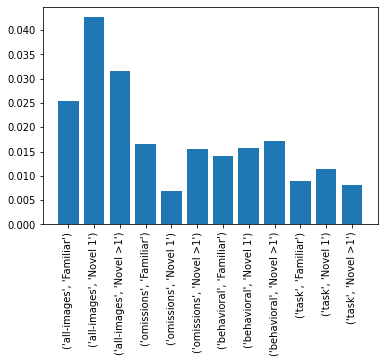

In [219]:
within_group_var = within_group_variability(cluster_data, cluster_means, overall_mean)
print(f"Within-group variability: {within_group_var}")
plt.bar(range(len(x)), within_group_var)
plt.xticks(ticks = range(len(x)), labels = x, rotation=90)